In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

from jax.scipy.special import gammaln

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [3]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


In [4]:
K = 2
N = 100
sigma = 0.01

alpha = 0.5 * jnp.ones(K,)

In [5]:
key, subkey = random.split(key)
pi = random.dirichlet(subkey, alpha)
print(pi)
print(jnp.sum(pi))

[0.12797161 0.87202839]
1.0


In [6]:
#pi = jnp.array([0.68387323, 0.31612677])

In [8]:
key, subkey = random.split(key)
z = random.categorical(subkey, jnp.log(pi), shape = (N,))
print(jnp.sum(z==0)/N)
print(jnp.sum(z==1)/N)

0.12
0.88


In [9]:
z

DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],            dtype=int64)

In [10]:
key, subkey = random.split(key)
x = random.normal(subkey, shape = (K,))
print(x)
#print(y.shape)

[ 0.67011936 -1.74377578]


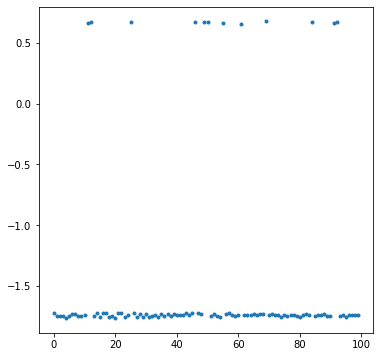

In [11]:
key, subkey = random.split(key)
y = x[z] + sigma * random.normal(subkey, shape = (N,))
plt.plot(y, '.')

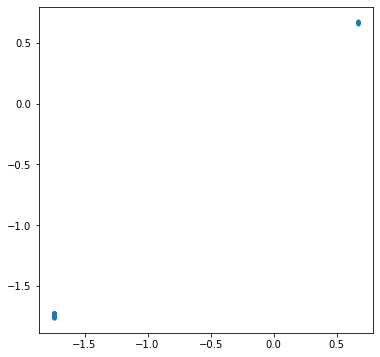

In [12]:
plt.plot(x[z], y, '.')

In [13]:
def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [14]:
calc_nik_jit(z).shape

(100, 2)

In [15]:
print(calc_nik_ki(z, 0, 13))
print(calc_nik_ki(z, 1, 13))
print(calc_nik_ki(z, 2, 13))

12
87
0


In [16]:
calc_nik_jit(z).shape

(100, 2)

In [17]:
pi

DeviceArray([0.12797161, 0.87202839], dtype=float64)

In [18]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

In [19]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   


In [20]:
probs_d

DeviceArray([[0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.115, 0.885],
             [0.115, 0.885],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.115, 0.885],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [0.125, 0.875],
             [

In [21]:
jnp.sum(probs_d, axis=1)

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float64)

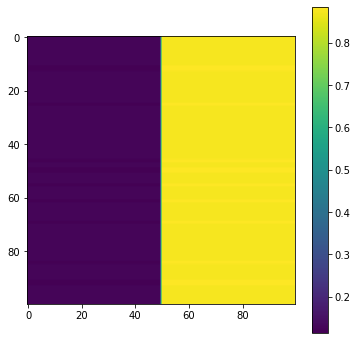

In [22]:
plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [23]:
print(pi)
print(z)

[0.12797161 0.87202839]
[1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]


In [24]:
z

DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],            dtype=int64)

In [25]:
n_ik_z.shape

(100, 2)

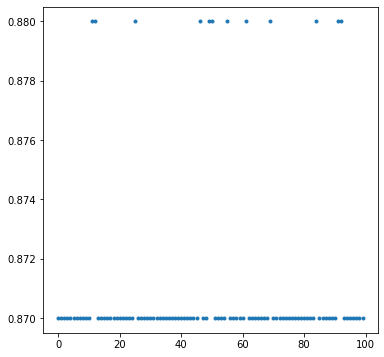

In [26]:
plt.plot(n_ik_z[:,4]/N,'.')

In [32]:
logPi(x, z, y, sigma, alpha)

DeviceArray(-80.1826701, dtype=float64)

In [33]:
pi

DeviceArray([0.12797161, 0.87202839], dtype=float64)

In [34]:
z

DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],            dtype=int64)

In [104]:
def logPi(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    # TODO: vectorize
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) * (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
        #log_arg += jnp.exp(jnp.exp(-(y - x[k])**2/sigma))*pi[k]
        
        logPZalpha += gammaln(n_k[k] + alpha[k])
    
    #print(logPZalpha)
    #print("term A ", jnp.sum(jnp.log(log_arg)) )
    #print("term B ", - jnp.sum(x**2))
    
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) + logPZalpha #, jnp.array(term_mat).transpose()
    #return logPZalpha #, jnp.array(term_mat).transpose()


In [105]:
key, subkey = random.split(key)
z0 = random.randint(subkey, z.shape, 0, K)
#z0 = jnp.ones(z.shape)
z0 = z
_, terms_01 = logPi(jnp.array([x[0], x[1]]), z, y, sigma, alpha)
_, terms_11 = logPi(jnp.array([x[1], x[1]]), z, y, sigma, alpha)
_, terms_00 = logPi(jnp.array([x[0], x[0]]), z, y, sigma, alpha)
_, terms_10 = logPi(jnp.array([x[1], x[0]]), z, y, sigma, alpha)

TypeError: iteration over a 0-d array

In [36]:
z0 = jnp.array([0,1,1])

In [37]:
logPi(jnp.array([x[0], x[1]]), z, y, sigma, alpha)
logPi(jnp.array([x[1], x[1]]), z, y, sigma, alpha)
logPi(jnp.array([x[0], x[0]]), z, y, sigma, alpha)
logPi(jnp.array([x[1], x[0]]), z, y, sigma, alpha)

DeviceArray(-226.93489702, dtype=float64)

In [38]:
jnp.exp(-(x[0]-y[0])**2/sigma)

DeviceArray(1.35312233e-250, dtype=float64)

In [39]:
print(terms_01)
print(terms_11)
print(terms_00)
print(terms_10)

NameError: name 'terms_01' is not defined

In [40]:
z

DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],            dtype=int64)

In [41]:
pi

DeviceArray([0.12797161, 0.87202839], dtype=float64)

In [42]:
xk = jnp.array([x[1],x[0]])
print(jnp.exp(-(y[0]-xk[0])**2/sigma))
print(jnp.exp(-(y[0]-xk[1])**2/sigma))

0.9769748658009433
1.3531223287019976e-250


In [43]:
print(x)
print(y[0])

[ 0.67011936 -1.74377578]
-1.7285132926527111


In [44]:
print(terms_10)

NameError: name 'terms_10' is not defined

In [45]:
jnp.sum(jnp.log(jnp.sum(terms_01, axis=1)))

NameError: name 'terms_01' is not defined

In [46]:
z_correct = z

In [47]:
@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    #print("z", z[:10])
    #print("z_correct", z_correct[:10])
    #print(jnp.sum(jnp.abs(z-z_correct)))
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x0(key, x00, logPiX0, B, x1, z, y, sigma, alpha):
    x01 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x00, x1]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x01, x1]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x01, r, logPiX1, logPiX0    

@jax.jit
def proposal_x1(key, x10, logPiX0, B, x0, z, y, sigma, alpha):
    x11 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x0, x10]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x0, x11]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x11, r, logPiX1, logPiX0    

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    z1 = random.randint(key, z0.shape, 0, K) 
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_one(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
   
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0



### First, sample x

In [48]:
print(pi)
print(x)

[0.12797161 0.87202839]
[ 0.67011936 -1.74377578]


  MCMC sample 1000, loss = 194.50528181358308, a = 0.0
  MCMC sample 2000, loss = 121.63383058284056, a = 0.0
  MCMC sample 3000, loss = 84.13618765790528, a = 0.0
  MCMC sample 4000, loss = 84.13618765790528, a = 0.0
  MCMC sample 5000, loss = 84.13618765790528, a = 0.0
  MCMC sample 6000, loss = 84.13618765790528, a = 0.0
  MCMC sample 7000, loss = 84.13618765790528, a = 0.0
  MCMC sample 8000, loss = 84.13618765790528, a = 0.0
  MCMC sample 9000, loss = 84.13618765790528, a = 0.0
[0.27450365 0.03632733]
[ 0.70507376 -1.72620063]
[ 0.67011936 -1.74377578]


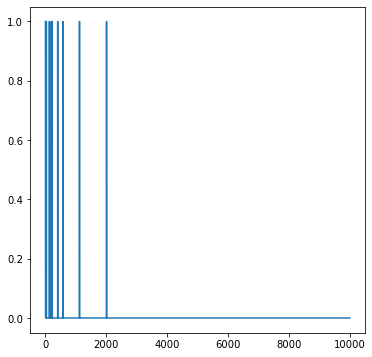

In [49]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


  MCMC sample 1000, loss = 80.64253494204173, a = 0.0
  MCMC sample 2000, loss = 80.8583841390859, a = 0.0
  MCMC sample 3000, loss = 81.43674394903374, a = 0.28495209754759404
  MCMC sample 4000, loss = 80.61631863261552, a = 3.4803980882461472e-227
  MCMC sample 5000, loss = 81.59603969794023, a = 0.0
  MCMC sample 6000, loss = 80.2484458835118, a = 0.0
  MCMC sample 7000, loss = 80.84275374505776, a = 0.0
  MCMC sample 8000, loss = 80.27826233431095, a = 4.7143911585625324e-94
  MCMC sample 9000, loss = 80.36628721035812, a = 0.0
  MCMC sample 10000, loss = 81.84961794527607, a = 0.0
0.6829971687566574
0.7054983126662555
[ 0.67011936 -1.74377578]


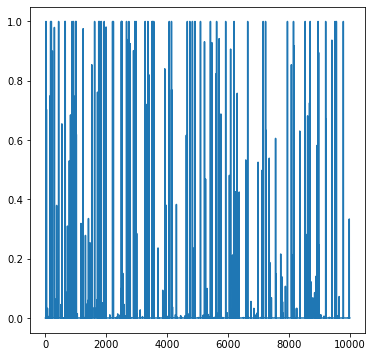

In [50]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x1" : x[1]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x0, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)

print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)

  MCMC sample 1000, loss = 80.33592558825418, a = 0.0
  MCMC sample 2000, loss = 81.45389600204778, a = 0.0
  MCMC sample 3000, loss = 80.23381795107895, a = 0.0
  MCMC sample 4000, loss = 80.49344641764225, a = 0.0
  MCMC sample 5000, loss = 81.93791708346481, a = 0.0
  MCMC sample 6000, loss = 82.94834532897016, a = 0.0
  MCMC sample 7000, loss = 80.24162418696082, a = 0.0
  MCMC sample 8000, loss = 80.5225955440996, a = 0.0
  MCMC sample 9000, loss = 80.44691096540627, a = 0.0
  MCMC sample 10000, loss = 80.53214919644796, a = 0.0
0.31741375273289363
-1.7489308214463724
[ 0.67011936 -1.74377578]


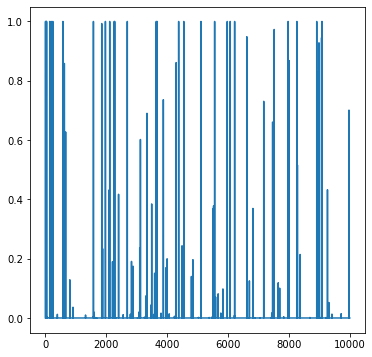

In [51]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x0" : x[0]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x1, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


In [52]:
logPi(x, z, y, sigma, alpha)


DeviceArray(-80.1826701, dtype=float64)

In [53]:
logPi(jnp.array([x[0],x[1]]), z, y, sigma, alpha)

DeviceArray(-80.1826701, dtype=float64)

In [54]:
logPi(jnp.array([x[1],x[1]]), z, y, sigma, alpha)

DeviceArray(-7029.40397599, dtype=float64)

In [55]:
x

DeviceArray([ 0.67011936, -1.74377578], dtype=float64)

In [56]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z0, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [57]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

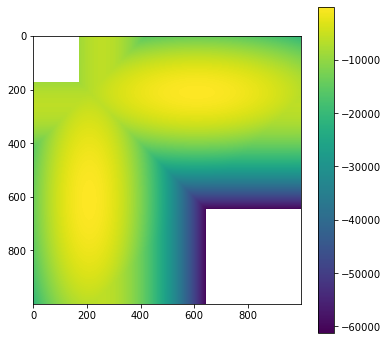

In [58]:
plt.imshow((myf_xy)); plt.colorbar()

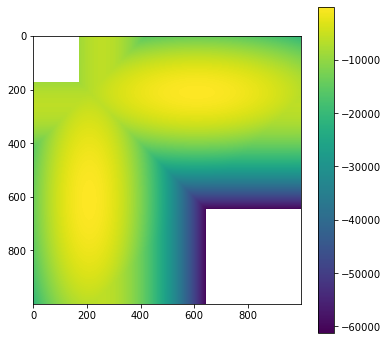

In [59]:
plt.imshow((myf_xy)); plt.colorbar()

In [60]:
jnp.log(8) + jnp.log(4)

DeviceArray(3.4657359, dtype=float64)

In [61]:
#plt.imshow(jnp.abs(myf_xy0-myf_xy2)); plt.colorbar()

In [62]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

01 -31.408679673460664
00 -51206.44679988842
11 -6965.045750477374
10 -70.3083881208121


In [63]:
myf(x[0],x[1])

DeviceArray(-31.40867967, dtype=float64)

In [64]:
jnp.max(myf_xy)

DeviceArray(-31.43683331, dtype=float64)

### Now sample z

In [65]:
z.shape

(100,)

In [66]:
x

DeviceArray([ 0.67011936, -1.74377578], dtype=float64)

  MCMC sample 1000, loss = 77.0184070171493, a = 6.3989974156551915e-34
  MCMC sample 2000, loss = 77.0184070171493, a = 1.4534169544642837e-34
  MCMC sample 3000, loss = 77.0184070171493, a = 1.0794979040109545e-28
  MCMC sample 4000, loss = 77.0184070171493, a = 2.386432947717629e-27
  MCMC sample 5000, loss = 77.0184070171493, a = 5.272226960601329e-28
  MCMC sample 6000, loss = 77.0184070171493, a = 5.478114326796023e-32
  MCMC sample 7000, loss = 77.0184070171493, a = 4.865459108953964e-28
  MCMC sample 8000, loss = 77.0184070171493, a = 1.1236265868525033e-28
  MCMC sample 9000, loss = 77.0184070171493, a = 5.936102102643737e-32
  MCMC sample 10000, loss = 77.0184070171493, a = 2.0811055970805743e-23
  MCMC sample 11000, loss = 77.0184070171493, a = 2.888268850232273e-31
  MCMC sample 12000, loss = 77.0184070171493, a = 1.215860405383357e-32
  MCMC sample 13000, loss = 77.0184070171493, a = 4.944460381519943e-30
  MCMC sample 14000, loss = 77.0184070171493, a = 1.215860405383357e

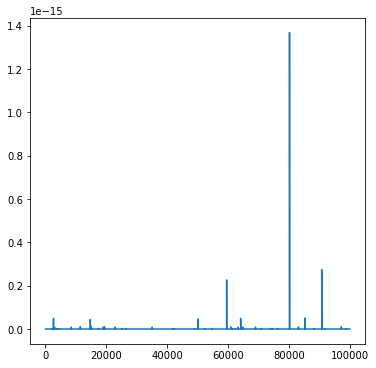

In [92]:
N_samples_z = 100001
#z0 = jnp.array(np.random.randint(0, K, (N,)))
z0 = random.categorical(subkey, jnp.log(pi), shape = (N,))

#z0 = z0.at[0].set(0)
#z0 = z0.at[1].set(0)
B = 3

#params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : 11}
params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z, z0, N_samples_z, params_z, 1, 1)
z_rec = z_samples[N_samples_z-2]
z_rec_m = jnp.mean(z_samples, axis=0)

plt.plot(z_r)
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec-z))/N)


In [93]:
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec_m-z))/N)

0.23
0.23


In [94]:
print(z0)
print(jnp.mean(z_samples, axis=0))
print(z)


[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1]
[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 1.]
[1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]


In [103]:
z_rec

DeviceArray([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
             1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
             1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
             0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],            dtype=int64)

In [ ]:
nbins=100
counts, bins = np.histogram(z_samples[:,9], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [2012]:
jnp.where(z ==1)

(DeviceArray([ 9, 10, 76, 96], dtype=int64),)

In [2013]:
jnp.where(z_rec_m > 0.5)

(DeviceArray([ 1,  2,  3,  5,  7,  8,  9, 11, 12, 13, 15, 16, 21, 22, 23,
              24, 25, 26, 27, 28, 31, 35, 36, 37, 38, 40, 46, 47, 49, 50,
              52, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 71, 73, 74, 75,
              76, 77, 78, 79, 80, 85, 88, 89, 91, 94, 97, 99], dtype=int64),)

In [2004]:
pi

DeviceArray([0.91638382, 0.08361618], dtype=float64)

In [1822]:
z

DeviceArray([1, 0, 0], dtype=int64)

In [1823]:
print(logPi(x, jnp.array([0,0,0]), y, sigma, alpha))
print(logPi(x, jnp.array([0,0,1]), y, sigma, alpha))
print(logPi(x, jnp.array([0,1,0]), y, sigma, alpha))
print(logPi(x, jnp.array([0,1,1]), y, sigma, alpha))
print(logPi(x, jnp.array([1,0,0]), y, sigma, alpha), "<-- true")
print(logPi(x, jnp.array([1,0,1]), y, sigma, alpha))
print(logPi(x, jnp.array([1,1,0]), y, sigma, alpha))
print(logPi(x, jnp.array([1,1,1]), y, sigma, alpha))



-2.770355754395285
-3.7920070019272667
-3.792007001927267
-3.792007001927267
-5.401444914361368 <-- true
-5.401444914361368
-5.401444914361368
-4.379793666829385


In [1815]:
pi

DeviceArray([0.63249074, 0.36750926], dtype=float64)

In [1816]:
alpha

DeviceArray([0.5, 0.5], dtype=float64)

In [1820]:
x

DeviceArray([-0.64361755,  0.40652684], dtype=float64)